In [3]:
!nvidia-smi

Wed Jan  6 16:38:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install fast-bert

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 3.0MB 12.7MB/s 
     |████████████████████████████████| 317kB 45.3MB/s 
     |████████████████████████████████| 778kB 43.6MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 1.1MB 50.6MB/s 
     |████████████████████████████████| 890kB 56.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=1ae328412adbfd5fa56711d37e5cbf9905f7b136011ddf4466397aade249ca2f
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=5632cf251cfa66e16b648c56dbfa5345520de78fd54f477d0c60e241810b5ad7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built seqeval sacremoses


In [9]:
from fast_bert.data_cls import BertDataBunch

DATA_PATH = "./processed_data/"
LABEL_PATH = "./processed_data/"

databunch = BertDataBunch(DATA_PATH, LABEL_PATH,
                          tokenizer='bert-base-uncased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='label.csv',
                          text_col='content',
                          label_col='genre',
                          batch_size_per_gpu=8,
                          max_seq_length=512,
                          multi_gpu=True,
                          multi_label=False,
                          model_type='bert')

In [10]:
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging
import torch

logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir='./out/',
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True,
						is_fp16=True,
						multi_label=False,
						logging_steps=50)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

/usr/local/lib/python3.6/dist-packages/pytorch_lamb/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


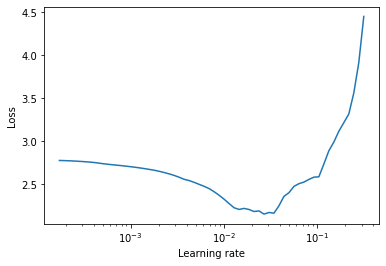

In [5]:
learner.lr_find(start_lr=5e-5,optimizer_type='lamb')

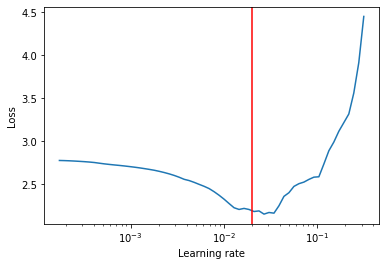

In [10]:
learner.plot(show_lr=2e-2)

In [12]:
learner.fit(epochs = 8,
			lr=2e-2,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")

/usr/local/lib/python3.6/dist-packages/pytorch_lamb/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(176, 0.9205816510981425)

In [21]:
learner.save_model()

In [ ]:
import pandas as pd

In [15]:
pred_docs = pd.read_csv('pred_docs.csv')
hw3_pred = pd.read_csv('hw3_sam.csv')

In [41]:
hw3_pred.head()

,Id,Value
0,17,0
1,18,0
2,20,0
3,21,0
4,22,0


In [19]:
from datetime import datetime

In [ ]:
for i in range(len(pred_docs)):
  corpus = pred_docs['content'][i]
  predictions = learner.predict_batch(corpus)
  hw3_pred['Value'][i] = int(predictions[0][0][0])
  print(i, ": ", predictions[0][0][0])
  
  now = datetime.now()
  current_time = now.strftime("%H:%M:%S")
  print("Current Time =", current_time)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


0 :  4
Current Time = 17:00:12
1 :  4
Current Time = 17:01:38
2 :  4
Current Time = 17:01:48
3 :  4
Current Time = 17:02:26
4 :  4
Current Time = 17:02:33
5 :  4
Current Time = 17:03:49
6 :  4
Current Time = 17:06:05
7 :  4
Current Time = 17:06:43
8 :  4
Current Time = 17:06:49
9 :  4
Current Time = 17:08:12
10 :  4
Current Time = 17:08:17
11 :  4
Current Time = 17:08:55
12 :  4
Current Time = 17:09:08
13 :  4
Current Time = 17:09:51
14 :  4
Current Time = 17:11:20
15 :  4
Current Time = 17:12:47
16 :  4
Current Time = 17:12:59
17 :  4
Current Time = 17:13:06


In [ ]:
hw3_pred